In [1]:
import tensorflow as tf
import numpy as np
import os
import random
from tensorflow import keras
from tensorflow.python.ops.rnn import static_rnn
from tensorflow.python.ops.rnn_cell_impl import BasicLSTMCell

# Prama Define

In [2]:
vocab_size=5000
max_seq_num = 380 #句子最大长度
num_dimensions = 50 #词向量长度 
batch_size = 100 # batch的尺寸
num_labels = 2  # 输出的类别数
iterations = 3750 # 迭代的次数 
dropout_keep_prob = 0.8  # dropout保留比例
learning_rate = 1e-3

# IMDB Dataset Import

In [3]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

In [4]:
#Size of train data and Test data
print(len(train_data))
print(len(test_data))

25000
25000


In [5]:
#Showcase of data example
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


Transform num vector data into word to have a intuitive view

In [6]:
# 字典:用于将数字转向单词
word_index = imdb.get_word_index()
 
# key值不变，value值加3，并新增了4个键值对
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0 # 用来将每一个sentence扩充到同等长度
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # 未知，可能是生僻单词或是人名
word_index["UNUSED"] = 3
 
# 将键值对的键与值互换
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
 
# 转译为原句
def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'?') for i in text])

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what the

Pad each piece of data

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,maxlen=max_seq_num) 
test_data = keras.preprocessing.sequence.pad_sequences(test_data,maxlen=max_seq_num)

# TF Graph Building

In [9]:
tf.compat.v1.disable_eager_execution()#在版本2.0下关闭急切运行模式，解决占位符模式冲突
tf.compat.v1.reset_default_graph()
X_holder = tf.compat.v1.placeholder(tf.int32, [None, max_seq_num])#Input_size of each: max_seq_num
Y_holder = tf.compat.v1.placeholder(tf.int32, [None])
embedding = tf.compat.v1.get_variable('embedding', [vocab_size, num_dimensions])#Embedding each piece of data into a vector
embedding_inputs = tf.nn.embedding_lookup(embedding, X_holder)
#Embedding result as RNN input
rnn_input = tf.unstack(embedding_inputs, max_seq_num, axis=1)
#一个由380个50维向量组成的二维张量
print("rnn_input shape:%s,%s"%(len(rnn_input),rnn_input[0].shape))
lstm_cell = BasicLSTMCell(64, forget_bias=1.0)
#将LSTM_CELL后面加dropout
lstm_cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=dropout_keep_prob)
rnn_outputs, rnn_states = static_rnn(lstm_cell, rnn_input, dtype=tf.float32)
# rnn_outputs是一个max_seq_num长度的数组，数组元素是(batch_size,64【LSTM细胞数】)张量
print("rnn_outputs shape:%s,%s"%(len(rnn_outputs),rnn_outputs[0].shape))
# rnn_states是一个2长度的数组，数组元素是(batch_size,64张量
print("rnn_states shape:%s,%s"%(len(rnn_states),rnn_states[0].shape))
#分类器
logits = tf.compat.v1.layers.dense(rnn_outputs[-1], num_labels)
predict_Y = tf.argmax(logits, axis=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
rnn_input shape:380,(None, 50)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
rnn_outputs shape:380,(None, 64)
rnn_states shape:2,(None, 64)
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


input: hidden state of LSTM
output:0/1 二分类

In [10]:
#测试集样本的正确或错误，计算交叉熵
losses = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(Y_holder, num_labels), logits = logits)
mean_loss = tf.reduce_mean(losses)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(mean_loss)
correct_pred = tf.equal(Y_holder, tf.cast(predict_Y, dtype=tf.int32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [11]:
# training
# 全局初始化
init = tf.compat.v1.global_variables_initializer()
session = tf.compat.v1.Session()
session.run(init)

In [12]:
iterations = 5000 # 迭代的次数 
steps = np.zeros(iterations)
ACC = np.zeros_like(steps)
MSE= np.zeros_like(steps)

In [13]:
import time

In [14]:
start = time.clock()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    print ("begin training")
    # 训练
    for step in range(iterations):
        #selected_index = random.sample(list(range(len(train_data))), k=batch_size)
        selected_index = np.random.choice(len(train_data),size=batch_size)
        batch_X = train_data[selected_index]
        batch_Y = train_labels[selected_index]
        feed_dict = {X_holder: batch_X, Y_holder: batch_Y}
        _, mean_loss_val,accuracy_value = sess.run([optimizer, mean_loss,accuracy], feed_dict=feed_dict)
        steps[step]=step
        ACC[step] = accuracy_value
        MSE[step] = mean_loss_val
        #print("rnn_outputs shape:%s,%s"%(len(rnn_outputs),rnn_outputs[0].shape))
        if step%100 == 0:
            print ("step = {}\t mean loss ={} acc ={}".format(step, mean_loss_val,accuracy_value))
elapsed = (time.clock() - start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


begin training
step = 0	 mean loss =0.6938297748565674 acc =0.4399999976158142
step = 100	 mean loss =0.5363131165504456 acc =0.7300000190734863
step = 200	 mean loss =0.33659180998802185 acc =0.8700000047683716
step = 300	 mean loss =0.2612231969833374 acc =0.8899999856948853
step = 400	 mean loss =0.1726425588130951 acc =0.9100000262260437
step = 500	 mean loss =0.2415950894355774 acc =0.9200000166893005
step = 600	 mean loss =0.1869545727968216 acc =0.9200000166893005
step = 700	 mean loss =0.22242766618728638 acc =0.9100000262260437
step = 800	 mean loss =0.1663917899131775 acc =0.9300000071525574
step = 900	 mean loss =0.30607113242149353 acc =0.8999999761581421
step = 1000	 mean loss =0.09201348572969437 acc =0.9700000286102295
step = 1100	 mean loss =0.18271896243095398 acc =0.9399999976158142
step = 1200	 mean loss =0.1260845810174942 acc =0.9700000286102295
step = 1300	 mean loss =0.12462357431650162 acc =0.9399999976158142
step = 1400	 mean loss =0.054190926253795624 acc =0.9

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [15]:
print("Time used:",elapsed)

Time used: 1947.5265663


In [16]:
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(init)
    # 存储Session工作空间
    saver_path = saver.save(sess, "./model/model_lstm_5000.ckpt")
    print ("Model saved in file: ", saver_path)

Model saved in file:  ./model/model_lstm_5000.ckpt


# 训练曲线

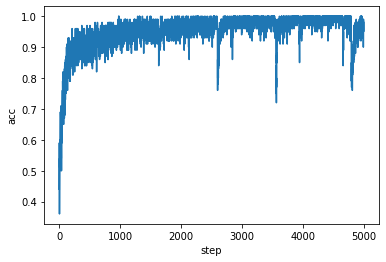

In [18]:
# plt image
import matplotlib.pyplot as plt
plt.plot(steps,ACC,label='acc')
plt.xlabel('step')
plt.ylabel('acc')
plt.show()

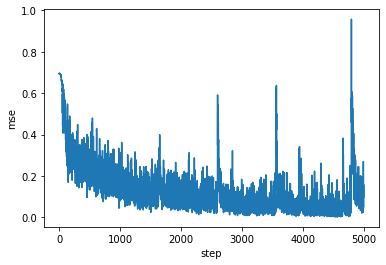

In [19]:
# plt image
import matplotlib.pyplot as plt
plt.plot(steps,MSE,label='mse')
plt.xlabel('step')
plt.ylabel('mse')
plt.show()

# Testset Evaluate：ACC, LOSS

In [20]:
def batch_iter(x, y, batch_size=64):
    """生成批次数据"""
    data_len = len(x)
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]

In [21]:
def evaluate(sess, x_, y_):
    """评估在某一数据上的准确率和损失"""
    data_len = len(x_)
    batch_eval = batch_iter(x_, y_, 64)
    total_loss = 0.0
    total_acc = 0.0
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        feed_dict = {X_holder: x_batch , Y_holder: y_batch}
        _, loss,acc = sess.run([optimizer, mean_loss,accuracy], feed_dict=feed_dict)
        total_loss += loss * batch_len
        total_acc += acc * batch_len

    return total_loss / data_len, total_acc / data_len

In [22]:
loss_test, acc_test = evaluate(session, test_data, test_labels)
print(loss_test)
print(acc_test)

0.40076295517921445
0.8124399999809265


# Precision, Recall and F1-Score.

In [24]:
batch_size = 128
data_len = len(test_data)
num_batch = int((data_len - 1) / batch_size) + 1

y_pred_cls = np.zeros(shape=len(test_data), dtype=np.int32)  # 保存预测结果
for i in range(num_batch):  # 逐批次处理
    start_id = i * batch_size
    end_id = min((i + 1) * batch_size, data_len)
    feed_dict = {X_holder: test_data[start_id:end_id]}
    y_pred_cls[start_id:end_id] = session.run(predict_Y , feed_dict=feed_dict)

In [26]:
from sklearn import metrics

print("Precision, Recall and F1-Score...")
print(metrics.classification_report(test_labels, y_pred_cls))

Precision, Recall and F1-Score...
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     12500
           1       0.94      0.85      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.91      0.90      0.90     25000
weighted avg       0.91      0.90      0.90     25000



In [27]:
# 混淆矩阵
print("Confusion Matrix...")
cm = metrics.confusion_matrix(test_labels, y_pred_cls)
print(cm)

Confusion Matrix...
[[11879   621]
 [ 1849 10651]]


# AUC ROC